# Investigate BDT Performance

The purpose of this notebook is to evaluate the performance of the BDT/combinatorics approach to reconstructing ttbar events. To reiterate, the strategy is to pass all possible permutations of jet assignments into the BDT and choose the result with the highest BDT score. Each permutation has four assignments: two jets are assigned to W, one jet is assigned to top1 (the top on the side of hadronic decay), and one jet is assigned to top2 (the top on the side of leptonic decay). Calculating every permutation is quite expensive as far as memory and time, so one purpose of this investigate is to find an appropriate cutoff for `MAX_N_JETS` (the maximum number of jets we consider for permutations in each event, where jets are ordered according to their $p_T$.

In [1]:
## IMPORTS
import os
import time

import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
from coffea.nanoevents import NanoEventsFactory
import awkward as ak

from sklearn.preprocessing import PowerTransformer
import xgboost as xgb

import utils

In [2]:
DICT_MAX = 8 # maximum permutation number to include in dictionaries

# calculate the dictionary of permutations for each number of jets
permutations_dict = {}
for n in range(4,DICT_MAX+1):
    test = ak.Array(range(n))
    unzipped = ak.unzip(ak.argcartesian([test]*4,axis=0))

    combos = ak.combinations(ak.Array(range(4)), 2, axis=0)
    different = unzipped[combos[0]["0"]]!=unzipped[combos[0]["1"]]
    for i in range(1,len(combos)):
        different = different & (unzipped[combos[i]["0"]]!=unzipped[combos[i]["1"]])

    permutations = ak.zip([test[unzipped[i][different]] for i in range(len(unzipped))],
                          depth_limit=1).tolist()


    permutations = ak.concatenate([test[unzipped[i][different]][..., np.newaxis] 
                                   for i in range(len(unzipped))], 
                                  axis=1).to_list()
    
    permutations_dict[n] = permutations
    
# for each permutation, calculate the corresponding label
labels_dict = {}
for n in range(4,DICT_MAX+1):
    
    current_labels = []
    for inds in permutations_dict[n]:
        
        inds = np.array(inds)
        current_label = 100*np.ones(n)
        current_label[inds[:2]] = 24
        current_label[inds[2]] = 6
        current_label[inds[3]] = -6
        current_labels.append(current_label.tolist())
        
    labels_dict[n] = current_labels
    
# get rid of duplicates since we consider W jets to be exchangeable
# (halves the number of permutations we consider)
for n in range(4,DICT_MAX+1):
    res = []
    for idx, val in enumerate(labels_dict[n]):
        if val in labels_dict[n][:idx]:
            res.append(idx)
    labels_dict[n] = np.array(labels_dict[n])[res].tolist()
    permutations_dict[n] = np.array(permutations_dict[n])[res].tolist()
    print("number of permutations for n=",n,": ", len(permutations_dict[n]))

number of permutations for n= 4 :  12
number of permutations for n= 5 :  60
number of permutations for n= 6 :  180
number of permutations for n= 7 :  420
number of permutations for n= 8 :  840


In [3]:
# these matrices tell you the overlap between the predicted label (rows) and truth label (columns)
# the "score" in each matrix entry is the number of jets which are assigned correctly
evaluation_matrices = {} # overall event score
evaluation_matrices_W = {} # score for W jets
evaluation_matrices_top2 = {} # score for top2 jet
evaluation_matrices_top1 = {} # score for top1 jet

for n in range(4,DICT_MAX+1):
    print("n = ", n)
    
    evaluation_matrix = np.zeros((len(permutations_dict[n]),len(permutations_dict[n])))
    evaluation_matrix_W = np.zeros((len(permutations_dict[n]),len(permutations_dict[n])))
    evaluation_matrix_top2 = np.zeros((len(permutations_dict[n]),len(permutations_dict[n])))
    evaluation_matrix_top1 = np.zeros((len(permutations_dict[n]),len(permutations_dict[n])))
    
    for i in range(len(permutations_dict[n])):
        for j in range(len(permutations_dict[n])):
            
            evaluation_matrix[i,j]=sum(np.equal(labels_dict[n][i], labels_dict[n][j]))
            evaluation_matrix_W[i,j]=4-len(np.union1d(np.where(np.array(labels_dict[n][i])==24)[0],
                                                      np.where(np.array(labels_dict[n][j])==24)[0]))
            evaluation_matrix_top2[i,j]=2-len(np.union1d(np.where(np.array(labels_dict[n][i])==6)[0],
                                                         np.where(np.array(labels_dict[n][j])==6)[0]))
            evaluation_matrix_top1[i,j]=2-len(np.union1d(np.where(np.array(labels_dict[n][i])==-6)[0],
                                                         np.where(np.array(labels_dict[n][j])==-6)[0]))
    
    evaluation_matrices[n] = evaluation_matrix
    evaluation_matrices_W[n] = evaluation_matrix_W
    evaluation_matrices_top2[n] = evaluation_matrix_top2
    evaluation_matrices_top1[n] = evaluation_matrix_top1

n =  4
n =  5
n =  6
n =  7
n =  8


In [4]:
## get inputs to BDT
def get_features(jets, electrons, muons, permutations_dict):
    '''
    Calculate features for each of the 12 combinations per event
    
    Args:
        jets: selected jets
        electrons: selected electrons
        muons: selected muons
        permutations_dict: which permutations to consider for each number of jets in an event
    
    Returns:
        features (flattened to remove event level)
    '''
    
    # calculate number of jets in each event
    njet = ak.num(jets).to_numpy()
    # don't consider every jet for events with high jet multiplicity
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[n] for n in njet])
    perm_counts = ak.num(perms)
    
    
    #### calculate features ####
    features = np.zeros((sum(perm_counts),19))
    
    # grab lepton info
    leptons = ak.flatten(ak.concatenate((electrons, muons),axis=1),axis=-1)

    # delta R between top1 and lepton
    features[:,0] = ak.flatten(np.sqrt((leptons.eta - jets[perms[...,3]].eta)**2 + 
                                       (leptons.phi - jets[perms[...,3]].phi)**2)).to_numpy()

    # delta R between the two W
    features[:,1] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,1]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,1]].phi)**2)).to_numpy()

    # delta R between W and top2
    features[:,2] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,2]].phi)**2)).to_numpy()
    features[:,3] = ak.flatten(np.sqrt((jets[perms[...,1]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,1]].phi - jets[perms[...,2]].phi)**2)).to_numpy()

    # delta phi between top1 and lepton
    features[:,4] = ak.flatten(np.abs(leptons.phi - jets[perms[...,3]].phi)).to_numpy()

    # delta phi between the two W
    features[:,5] = ak.flatten(np.abs(jets[perms[...,0]].phi - jets[perms[...,1]].phi)).to_numpy()

    # delta phi between W and top2
    features[:,6] = ak.flatten(np.abs(jets[perms[...,0]].phi - jets[perms[...,2]].phi)).to_numpy()
    features[:,7] = ak.flatten(np.abs(jets[perms[...,1]].phi - jets[perms[...,2]].phi)).to_numpy()


    # combined mass of top1 and lepton
    features[:,8] = ak.flatten((leptons + jets[perms[...,3]]).mass).to_numpy()

    # combined mass of W
    features[:,9] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]]).mass).to_numpy()

    # combined mass of W and top2
    features[:,10] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]] + 
                                 jets[perms[...,2]]).mass).to_numpy()


    # pt of every jet
    features[:,11] = ak.flatten(jets[perms[...,0]].pt).to_numpy()
    features[:,12] = ak.flatten(jets[perms[...,1]].pt).to_numpy()
    features[:,13] = ak.flatten(jets[perms[...,2]].pt).to_numpy()
    features[:,14] = ak.flatten(jets[perms[...,3]].pt).to_numpy()


    # mass of every jet
    features[:,15] = ak.flatten(jets[perms[...,0]].mass).to_numpy()
    features[:,16] = ak.flatten(jets[perms[...,1]].mass).to_numpy()
    features[:,17] = ak.flatten(jets[perms[...,2]].mass).to_numpy()
    features[:,18] = ak.flatten(jets[perms[...,3]].mass).to_numpy()

    return features, perm_counts

In [5]:
def filterEvents(jets, electrons, muons, genpart, nmin, nmax, reconstructable=True):

    
    selected_electrons = electrons[electrons.pt > 25]
    # selected_electrons = electrons[(electrons.pt > 30) & (np.abs(electrons.eta)<2.1) & (electrons.sip3d < 4) & (electrons.cutBased==4)]
    selected_muons = muons[muons.pt > 25]
    # selected_muons = events.Muon[(muons.pt > 30) & (np.abs(muons.eta)<2.1) & (muons.tightId) & 
    #                              (muons.sip3d < 4) & (muons.pfRelIso04_all < 0.15)]
    jet_filter = (jets.pt > 25)
    # jet_filter = (jets.pt > 30) & (np.abs(jets.eta) < 2.4)
    selected_jets = jets[jet_filter]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= nmin)
    # at least one b-tagged jet ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

    print("        ", 100*np.round(sum(event_filters)/num_events,4), "% of events survived event_filters")

    selected_events = events[event_filters]
    selected_electrons = selected_electrons[event_filters]
    selected_muons = selected_muons[event_filters]
    selected_jets = selected_jets[event_filters]
    selected_genpart = genpart[event_filters]

    ### only consider 4j2b region
    region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2

    print("        ", 100*np.round(sum(region_filter)/num_events,4), "% of events survived region_filter")

    selected_jets_region = selected_jets[region_filter][:,:nmax] # only keep top n jets
    selected_electrons_region = selected_electrons[region_filter]
    selected_muons_region = selected_muons[region_filter]
    selected_genpart_region = selected_genpart[region_filter]
    
    
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = selected_genpart_region.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    selected_genpart_region_reduced = selected_genpart_region[genpart_filter]
    genpart_parent_reduced = selected_genpart_region_reduced.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                       (np.abs(genpart_parent_reduced.pdgId)==24))
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(selected_genpart_region_reduced.pdgId)<7) & 
                       (np.abs(selected_genpart_region_reduced.pdgId)>0))
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = selected_genpart_region_reduced.hasFlags("isLastCopy")
    selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter4]
    
    # match jets to nearest valid genPart candidate
    nearest_genpart = selected_jets_region.nearest(selected_genpart_region_reduced, 
                                                   threshold=1.0)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle

    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    jet_counts = ak.num(selected_jets_region)
    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience
    
    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)
    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False)
    
    has_both_cousins_flat = ak.flatten(has_both_cousins)
    # get labels from parent pdgId (fill none with 100 to filter them)
    labels_flat = np.abs(ak.fill_none(ak.flatten(parent_pdgid),100).to_numpy())
    labels_flat[has_both_cousins_flat] = -6 # assign jets with both cousins as top1
    
    labels = ak.unflatten(labels_flat, jet_counts)

    if reconstructable:
        has_W = ak.sum(labels==24,axis=-1) == 2
        has_top2 = ak.sum(labels==6,axis=-1) == 1
        has_top1 = ak.sum(labels==-6,axis=-1) == 1
        training_event_filter = has_W & has_top2 & has_top1

        print(f"        Training Filter Keeps {100*sum(training_event_filter)/len(training_event_filter)}% of Events")

        selected_jets_region = selected_jets_region[training_event_filter]
        selected_electrons_region = selected_electrons_region[training_event_filter]
        selected_muons_region = selected_muons_region[training_event_filter]
        labels = labels[training_event_filter]
    
    return selected_jets_region, selected_electrons_region, selected_muons_region, labels

In [6]:
# load model
model = xgb.XGBClassifier()
model.load_model("models/model_xgb_230206.json")

In [7]:
# load data 
num_events = 100_000
events = NanoEventsFactory.from_root("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.root", 
                                     treepath="Events", entry_stop=num_events).events()


/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


# Evaluation 1

First, we evaluate the performance by restricting the sample of events to those in which it is possible to construct all truth labels.

In [8]:
# set the max number of jets to consider for the first part of the study
MAX_N_JETS = 7

         31.04 % of events survived event_filters
         20.630000000000003 % of events survived region_filter
        Training Filter Keeps 17.805995105047618% of Events
filtered events
calculated perms
calculated labels


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


calculated features
preprocessed features
obtained predictions
calculated scores


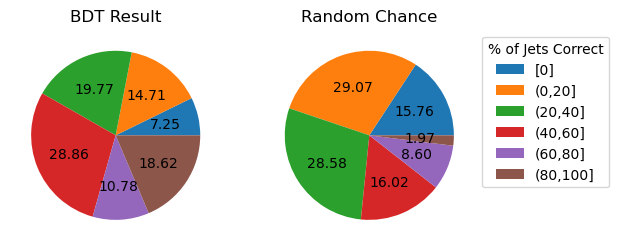

In [9]:
### SCORE NOT SEPARATED BY NJET

jets, electrons, muons, labels = filterEvents(events.Jet, events.Electron, events.Muon, events.GenPart, 4, MAX_N_JETS)
print("filtered events")
    
njet = ak.num(jets).to_numpy()
njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
# create awkward array of permutation indices
perms = ak.Array([permutations_dict[k] for k in njet])
perms_to_labels = ak.Array([labels_dict[k] for k in njet])
print("calculated perms")

# calculate event-level labels
# which combination does the truth label correspond to?
which_combination = np.zeros(len(jets), dtype=int)
combination_labels = []

for i in range(len(jets)):
    for j in range(len(perms_to_labels[i])):
        if np.array_equal(perms_to_labels[i][j],labels[i]):
            which_combination[i] = j
            combination_labels.append(1)
        else: 
            combination_labels.append(0)

combination_labels = np.array(combination_labels)
print("calculated labels")
    
# get features
features, perm_counts = get_features(jets, 
                                     electrons, 
                                     muons, 
                                     permutations_dict)
print("calculated features")

# preprocess features so that they are more Gaussian-like
power = PowerTransformer(method='yeo-johnson', standardize=True)
features = power.fit_transform(features)
print("preprocessed features")

# get predictions
predictions = model.predict_proba(features)[:,1]
print("obtained predictions")

BDT_results = ak.unflatten(predictions, perm_counts)
BDT_result_combination = ak.argmax(BDT_results,axis=1)

# calculate performance
score_total = np.zeros(len(which_combination))

zipped = list(zip(which_combination.tolist(), BDT_result_combination.tolist()))
for i in range(len(which_combination)):
    score_total[i] = evaluation_matrices[njet[i]][zipped[i]]/njet[i]

jet_distribution = np.array([sum(njet==i)/len(njet) for i in range(4,MAX_N_JETS+1)])
bdt_score_mat = np.zeros((6,MAX_N_JETS-3)) # rows correspond to brackets, columns correspond to njets
random_score_mat = np.zeros((6,MAX_N_JETS-3)) # rows correspond to brackets, columns correspond to njets

# calculate score for number of jets for each bracket
for n in range(4, MAX_N_JETS+1):
    
    # bdt scores
    bdt_score_mat[0,n-4] = np.average(score_total[njet==n]==0.0)
    bdt_score_mat[1,n-4] = np.average((score_total[njet==n]>0.0) & (score_total[njet==n]<=0.2))
    bdt_score_mat[2,n-4] = np.average((score_total[njet==n]>0.2) & (score_total[njet==n]<=0.4))
    bdt_score_mat[3,n-4] = np.average((score_total[njet==n]>0.4) & (score_total[njet==n]<=0.6))
    bdt_score_mat[4,n-4] = np.average((score_total[njet==n]>0.6) & (score_total[njet==n]<=0.8))
    bdt_score_mat[5,n-4] = np.average((score_total[njet==n]>0.8) & (score_total[njet==n]<=1.0))
    
    # scores from random chance
    random_score_mat[0,n-4] = np.average((1/n)*evaluation_matrices[n][0,:]==0.0)
    random_score_mat[1,n-4] = np.average(((1/n)*evaluation_matrices[n][0,:]>0.0) & ((1/n)*evaluation_matrices[n][0,:]<=0.2))
    random_score_mat[2,n-4] = np.average(((1/n)*evaluation_matrices[n][0,:]>0.2) & ((1/n)*evaluation_matrices[n][0,:]<=0.4))
    random_score_mat[3,n-4] = np.average(((1/n)*evaluation_matrices[n][0,:]>0.4) & ((1/n)*evaluation_matrices[n][0,:]<=0.6))
    random_score_mat[4,n-4] = np.average(((1/n)*evaluation_matrices[n][0,:]>0.6) & ((1/n)*evaluation_matrices[n][0,:]<=0.8))
    random_score_mat[5,n-4] = np.average(((1/n)*evaluation_matrices[n][0,:]>0.8) & ((1/n)*evaluation_matrices[n][0,:]<=1.0))

# calculate weighted average using distribution of number of jets
bdt_scores = np.matmul(bdt_score_mat, jet_distribution)
random_scores = np.matmul(random_score_mat, jet_distribution)
print("calculated scores")


# make pie charts
fig, axs = plt.subplots(1,2,figsize=(6,4))

axs[0].pie(bdt_scores,autopct='%.2f')
axs[1].pie(random_scores,autopct='%.2f')
axs[0].set_title(f"BDT Result")
axs[1].set_title(f"Random Chance")
axs[1].legend(["[0]","(0,20]","(20,40]","(40,60]","(60,80]","(80,100]"], 
              bbox_to_anchor=(1,1), title = "% of Jets Correct")
                    
fig.show()

# Evaluation 2

Next, we evaluate the performance for all events in which it is possible to fully reconstruct, but separate the calculations by number of jets (and type of jet/jet label)

In [10]:
# scores not separated by jet label
bdt_score_dict = {}
random_score_dict = {}

# bdt scores separated by jet label
bdt_W_score_dict = {}
bdt_top2_score_dict = {}
bdt_top1_score_dict = {}

# random chance scores separated by jet label
random_W_score_dict = {}
random_top2_score_dict = {}
random_top1_score_dict = {}


for n in range(4,MAX_N_JETS+1):
    
    print("n = ", n)
    # filter data
    jets, electrons, muons, labels = filterEvents(events.Jet, events.Electron, events.Muon, events.GenPart, n, n)
    print("    filtered events")
    
    njet = ak.num(jets).to_numpy()
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[k] for k in njet])
    perms_to_labels = ak.Array([labels_dict[k] for k in njet])
    print("    calculated perms")

    # calculate event-level labels
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    combination_labels = []

    for i in range(len(jets)):
        for j in range(len(perms_to_labels[i])):
            if np.array_equal(perms_to_labels[i][j],labels[i]):
                which_combination[i] = j
                combination_labels.append(1)
            else: 
                combination_labels.append(0)

    combination_labels = np.array(combination_labels)
    print("    calculated labels")
    
    # get features
    features, perm_counts = get_features(jets, 
                                         electrons, 
                                         muons, 
                                         permutations_dict)
    print("    calculated features")

    # preprocess features so that they are more Gaussian-like
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    features = power.fit_transform(features)
    print("    preprocessed features")

    # get predictions
    predictions = model.predict_proba(features)[:,1]
    print("    obtained predictions")

    BDT_results = ak.unflatten(predictions, perm_counts)
    BDT_result_combination = ak.argmax(BDT_results,axis=1)

    # calculate performance
    score_total = np.zeros(len(which_combination))
    score_W = np.zeros(len(which_combination))
    score_top2 = np.zeros(len(which_combination))
    score_top1 = np.zeros(len(which_combination))

    zipped = list(zip(which_combination.tolist(), BDT_result_combination.tolist()))
    for i in range(len(which_combination)):
        score_total[i] = evaluation_matrices[njet[i]][zipped[i]]
        score_W[i] = evaluation_matrices_W[njet[i]][zipped[i]]
        score_top2[i] = evaluation_matrices_top2[njet[i]][zipped[i]]
        score_top1[i] = evaluation_matrices_top1[njet[i]][zipped[i]]

    # scores not separated by jet label
    bdt_scores_total = np.zeros(n+1)
    random_scores = np.zeros(n+1)
    
    for i in range(n+1):
        bdt_scores_total[i] = sum(score_total==i)/len(score_total)
        random_scores[i] = sum(evaluation_matrices[n][:,0]==i)/n
        
    bdt_score_dict[n] = bdt_scores_total
    random_score_dict[n] = random_scores
    
    # scores for W jets
    W_scores = np.zeros(3)
    random_scores = np.zeros(3)
    for i in range(3):
        W_scores[i] =  sum(score_W==i)/len(score_W)
        random_scores[i] = sum(evaluation_matrices_W[n][:,0]==i)/n
        
    bdt_W_score_dict[n] = W_scores
    random_W_score_dict[n] = random_scores
        
    # scores for top1 and top2 jets
    top2_scores = np.zeros(2)
    top1_scores = np.zeros(2)
    random_scores2 = np.zeros(3)
    random_scores1 = np.zeros(3)
    for i in range(2):
        top2_scores[i] =  sum(score_top2==i)/len(score_top2)
        top1_scores[i] =  sum(score_top1==i)/len(score_top1)
        random_scores2[i] = sum(evaluation_matrices_top2[n][:,0]==i)/n
        random_scores1[i] = sum(evaluation_matrices_top1[n][:,0]==i)/n
        
    bdt_top2_score_dict[n] = top2_scores
    bdt_top1_score_dict[n] = top1_scores
    random_top2_score_dict[n] = random_scores2
    random_top1_score_dict[n] = random_scores1
    
    print("    calculated scores")

n =  4
         31.04 % of events survived event_filters
         20.630000000000003 % of events survived region_filter
        Training Filter Keeps 7.739840550560981% of Events
    filtered events
    calculated perms
    calculated labels


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    calculated scores
n =  5
         24.47 % of events survived event_filters
         17.05 % of events survived region_filter
        Training Filter Keeps 15.618310313480544% of Events
    filtered events
    calculated perms
    calculated labels


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    calculated scores
n =  6
         15.540000000000001 % of events survived event_filters
         11.34 % of events survived region_filter
        Training Filter Keeps 14.831312017640574% of Events
    filtered events
    calculated perms
    calculated labels


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    calculated scores
n =  7
         8.44 % of events survived event_filters
         6.419999999999999 % of events survived region_filter
        Training Filter Keeps 12.437655860349127% of Events
    filtered events
    calculated perms
    calculated labels


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    calculated scores


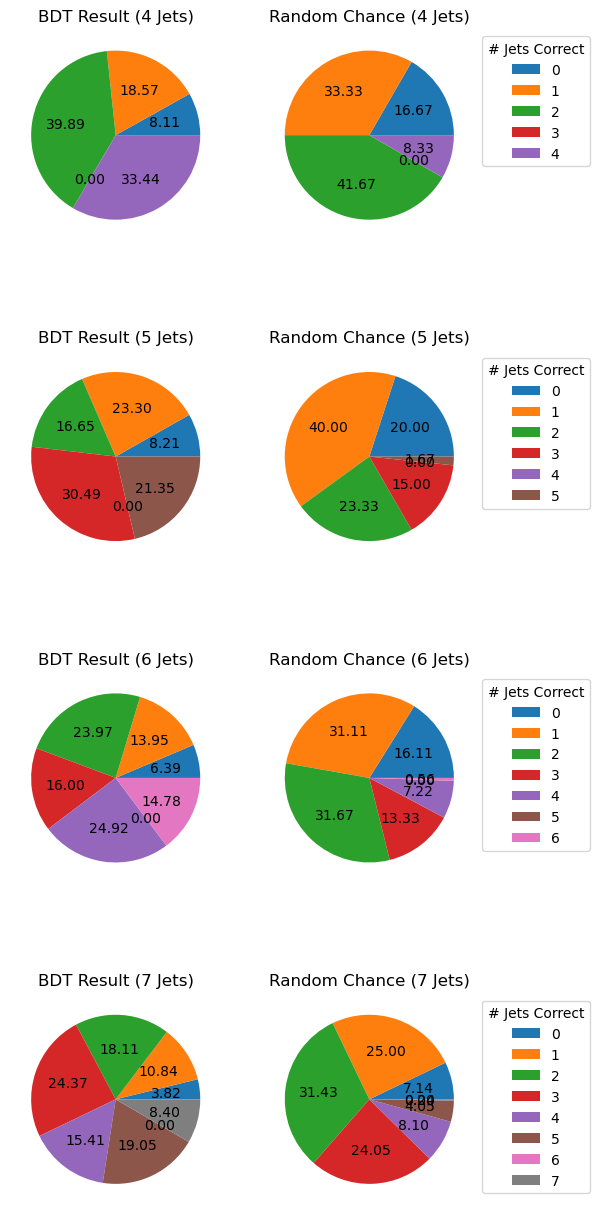

In [11]:
# plots with all jet labels together
fig, axs = plt.subplots(MAX_N_JETS-3,2,figsize=(6,4*(MAX_N_JETS-3)))

for i in range(MAX_N_JETS-3):

    axs[i,0].pie(bdt_score_dict[i+4],autopct='%.2f')
    axs[i,1].pie(random_score_dict[i+4],autopct='%.2f')
    axs[i,0].set_title(f"BDT Result ({i+4} Jets)")
    axs[i,1].set_title(f"Random Chance ({i+4} Jets)")
    
    axs[i,1].legend(range(len(bdt_score_dict[i+4])), bbox_to_anchor=(1,1), title = "# Jets Correct")
                    
fig.show()

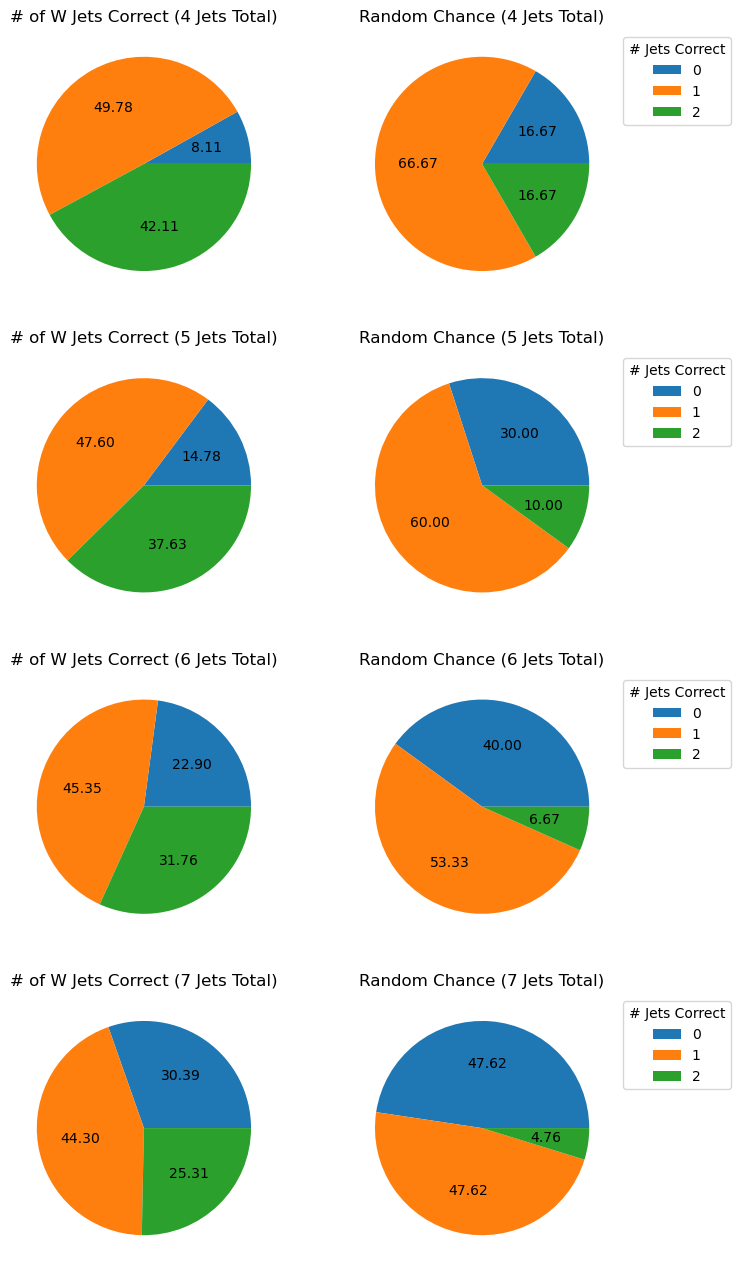

In [12]:
# plots for W jets
fig, axs = plt.subplots(MAX_N_JETS-3,2,figsize=(8,4*(MAX_N_JETS-3)))

for i in range(MAX_N_JETS-3):

    axs[i,0].pie(bdt_W_score_dict[i+4],autopct='%.2f')
    axs[i,1].pie(random_W_score_dict[i+4],autopct='%.2f')
    axs[i,0].set_title(f"# of W Jets Correct ({i+4} Jets Total)")
    axs[i,1].set_title(f"Random Chance ({i+4} Jets Total)")
    
    axs[i,1].legend(range(len(bdt_W_score_dict[i+4])), bbox_to_anchor=(1,1), title = "# Jets Correct")
                    
fig.show()

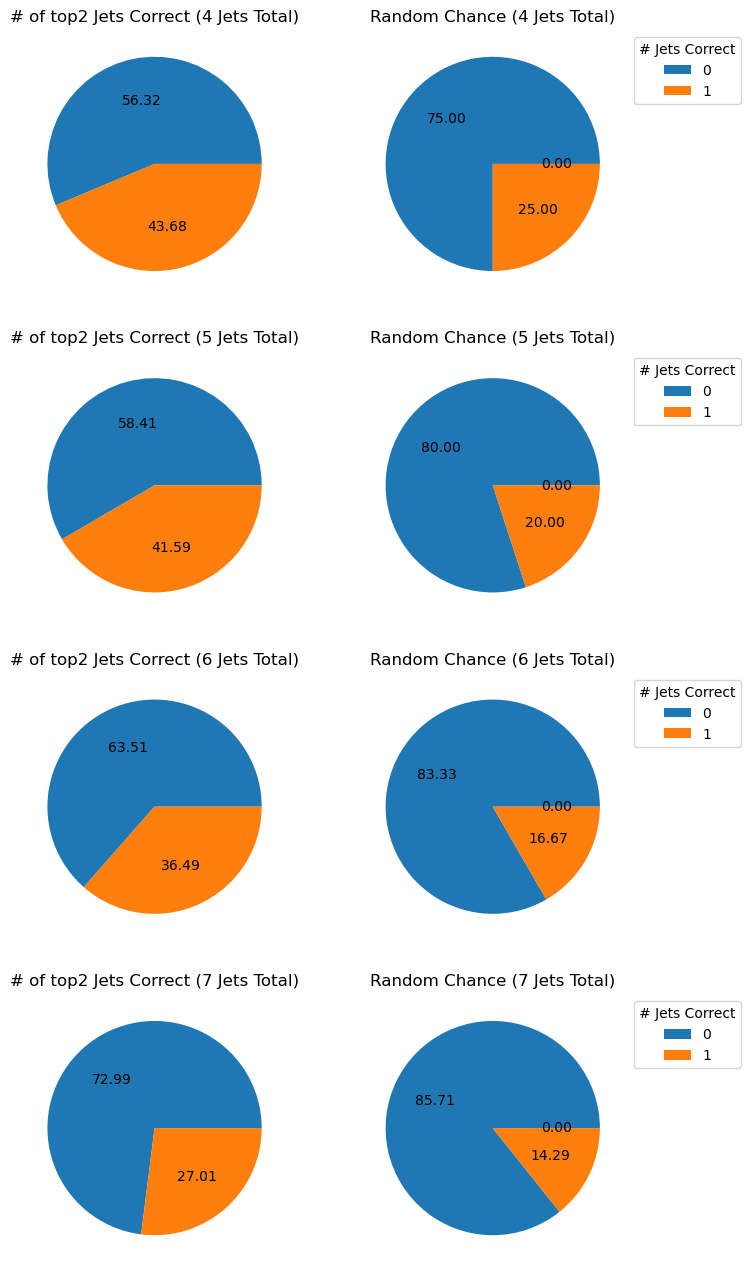

In [13]:
# plots for top2 jets
fig, axs = plt.subplots(MAX_N_JETS-3,2,figsize=(8,4*(MAX_N_JETS-3)))

for i in range(MAX_N_JETS-3):

    axs[i,0].pie(bdt_top2_score_dict[i+4],autopct='%.2f')
    axs[i,0].set_title(f"# of top2 Jets Correct ({i+4} Jets Total)")
    
    axs[i,1].pie(random_top2_score_dict[i+4],autopct='%.2f')
    axs[i,1].set_title(f"Random Chance ({i+4} Jets Total)")
    
    axs[i,1].legend(range(len(bdt_top2_score_dict[i+4])), bbox_to_anchor=(1,1), title = "# Jets Correct")
                    
fig.show()

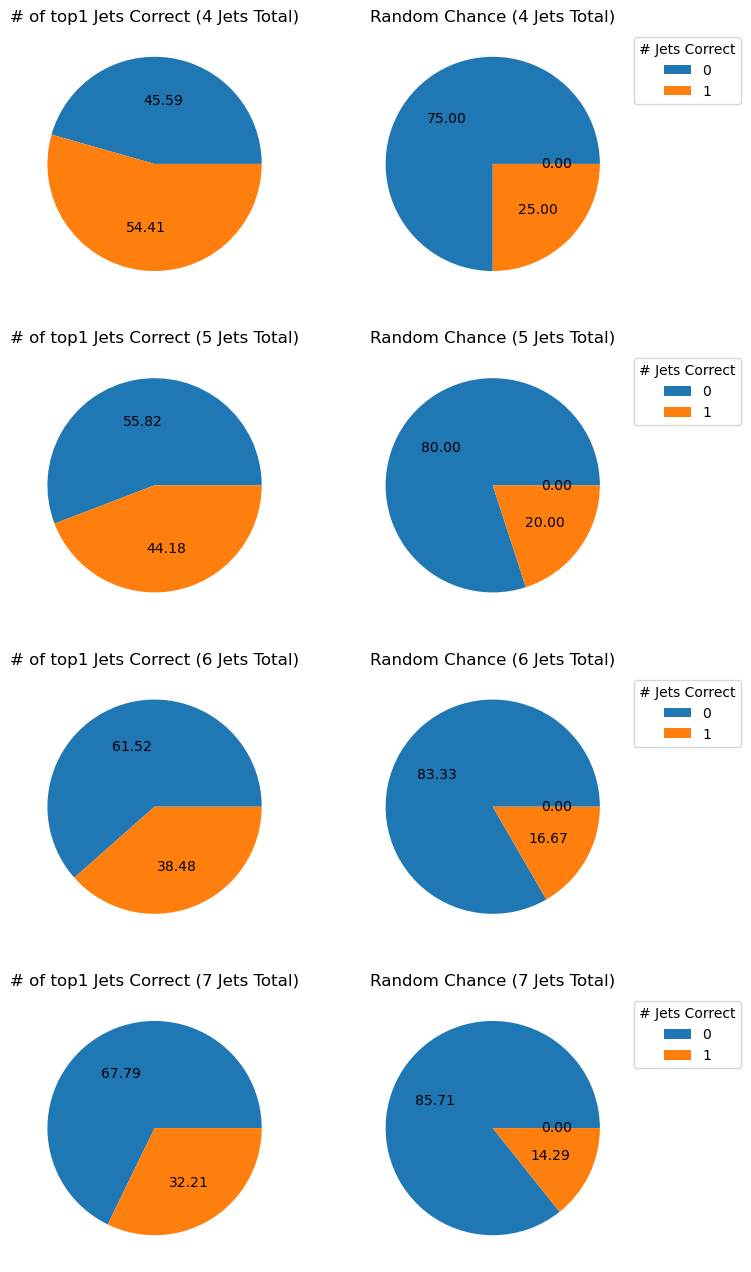

In [14]:
# plots for top1 jets
fig, axs = plt.subplots(MAX_N_JETS-3,2,figsize=(8,4*(MAX_N_JETS-3)))

for i in range(MAX_N_JETS-3):

    axs[i,0].pie(bdt_top1_score_dict[i+4],autopct='%.2f')
    axs[i,0].set_title(f"# of top1 Jets Correct ({i+4} Jets Total)")
    
    axs[i,1].pie(random_top1_score_dict[i+4],autopct='%.2f')
    axs[i,1].set_title(f"Random Chance ({i+4} Jets Total)")
    
    axs[i,1].legend(range(len(bdt_top1_score_dict[i+4])), bbox_to_anchor=(1,1), title = "# Jets Correct")
                    
fig.show()

# Evaluation 3

Now we want to see the effect of `MAX_N_JETS` on overall efficiency. So we will not filter to events that are fully reconstructable.

In [8]:
MAX_N_JETS_LIST = list(range(4,8)) # values of MAX_N_JETS to consider

In [ ]:
bdt_score_dict = {}
fig, axs = plt.subplots(len(MAX_N_JETS_LIST),4,figsize=(14,4*len(MAX_N_JETS_LIST)))

score_avg_all = np.zeros(len(MAX_N_JETS_LIST))
score_avg_W = np.zeros(len(MAX_N_JETS_LIST))
score_avg_top2 = np.zeros(len(MAX_N_JETS_LIST))
score_avg_top1 = np.zeros(len(MAX_N_JETS_LIST))

for MAX_N_JETS in MAX_N_JETS_LIST:

    print("MAX_N_JETS = ", MAX_N_JETS)
    jets, electrons, muons, labels = filterEvents(events.Jet, events.Electron, events.Muon, events.GenPart, 
                                                  4, MAX_N_JETS, reconstructable=False)
    print("    filtered events")
    
    njet = ak.num(jets).to_numpy()
    njet[njet>MAX_N_JETS] = MAX_N_JETS
    
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[k] for k in njet])
    perms_to_labels = ak.Array([labels_dict[k] for k in njet])
    print("    calculated perms")
    
    # get features
    features, perm_counts = get_features(jets, 
                                         electrons, 
                                         muons, 
                                         permutations_dict)
    print("    calculated features")

    # preprocess features so that they are more Gaussian-like
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    features = power.fit_transform(features)
    print("    preprocessed features")

    # get predictions
    predictions = model.predict_proba(features)[:,1]
    print("    obtained predictions")

    BDT_results = ak.unflatten(predictions, perm_counts)
    BDT_result_combination = ak.argmax(BDT_results,axis=1)
    label_result = ak.flatten(perms_to_labels[ak.from_regular(BDT_result_combination[:, np.newaxis])])

    where_W_result = (label_result==24)
    where_top2_result = (label_result==6)
    where_top1_result = (label_result==-6)

    where_W_truth = (labels==24)
    where_top2_truth = (labels==6)
    where_top1_truth = (labels==-6)
    print("    obtained results")
    
    W_correct = np.zeros(len(label_result))
    top1_correct = np.zeros(len(label_result))
    top2_correct = np.zeros(len(label_result))
    all_correct = np.zeros(len(label_result))
    
    for evtnum in range(len(label_result)):

        for ind in np.where(where_W_truth[evtnum])[0]:
            if ind in np.where(where_W_result[evtnum])[0]: 
                W_correct[evtnum] += 1
        if W_correct[evtnum]>2: W_correct[evtnum] = 2

        for ind in np.where(where_top2_truth[evtnum])[0]:
            if ind in np.where(where_top2_result[evtnum])[0]: 
                top2_correct[evtnum] += 1
        if  top2_correct[evtnum]>1:  top2_correct[evtnum] = 1

        found_top1_count = 0
        for ind in np.where(where_top1_truth[evtnum])[0]:
            if ind in np.where(where_top1_result[evtnum])[0]: 
                 top1_correct[evtnum] += 1
        if  top1_correct[evtnum]>1:  top1_correct[evtnum] = 1
        
        all_correct[evtnum] = W_correct[evtnum] + top2_correct[evtnum] + top1_correct[evtnum]
    
    print("    calculated scores")
    
    score_avg_all[MAX_N_JETS-4] = np.average(all_correct)
    score_avg_W[MAX_N_JETS-4] = np.average(W_correct)
    score_avg_top2[MAX_N_JETS-4] = np.average(top2_correct)
    score_avg_top1[MAX_N_JETS-4] = np.average(top1_correct)
    
    # make pie charts
    axs[MAX_N_JETS-4,0].pie([sum(all_correct==0)/len(all_correct), 
                             sum(all_correct==1)/len(all_correct), 
                             sum(all_correct==2)/len(all_correct), 
                             sum(all_correct==3)/len(all_correct), 
                             sum(all_correct==4)/len(all_correct)],
                            autopct='%.2f')
    axs[MAX_N_JETS-4,0].set_title(f"MAX_N_JETS={MAX_N_JETS}: All Labels")
    axs[MAX_N_JETS-4,0].legend([0,1,2,3,4], title="# Correct", loc='upper right', bbox_to_anchor=(1.3,1))
    axs[MAX_N_JETS-4,1].pie([sum(W_correct==0)/len(W_correct), 
                             sum(W_correct==1)/len(W_correct), 
                             sum(W_correct==2)/len(W_correct)],
                            autopct='%.2f')
    axs[MAX_N_JETS-4,1].set_title(f"MAX_N_JETS={MAX_N_JETS}: W Jets")
    axs[MAX_N_JETS-4,1].legend([0,1,2], title="# Correct", loc='upper right', bbox_to_anchor=(1.3,1))
    
    axs[MAX_N_JETS-4,2].pie([sum(top2_correct==0)/len(top2_correct), 
                             sum(top2_correct==1)/len(top2_correct)],
                            autopct='%.2f')
    axs[MAX_N_JETS-4,2].set_title(f"MAX_N_JETS={MAX_N_JETS}: top2 Jets")
    axs[MAX_N_JETS-4,2].legend([0,1], title="# Correct", loc='upper right', bbox_to_anchor=(1.3,1))
    
    axs[MAX_N_JETS-4,3].pie([sum(top1_correct==0)/len(top1_correct), 
                             sum(top1_correct==1)/len(top1_correct)],
                            autopct='%.2f')
    axs[MAX_N_JETS-4,3].set_title(f"MAX_N_JETS={MAX_N_JETS}: top1 Jets")
    axs[MAX_N_JETS-4,3].legend([0,1], title="# Correct", loc='upper right', bbox_to_anchor=(1.3,1))

plt.show()

MAX_N_JETS =  4
         30.72 % of events survived event_filters
         20.46 % of events survived region_filter
    filtered events
    calculated perms


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    obtained results
    calculated scores
MAX_N_JETS =  5
         30.72 % of events survived event_filters
         20.46 % of events survived region_filter
    filtered events
    calculated perms


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    obtained results
    calculated scores
MAX_N_JETS =  6
         30.72 % of events survived event_filters
         20.46 % of events survived region_filter
    filtered events
    calculated perms


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features
    preprocessed features
    obtained predictions
    obtained results
    calculated scores
MAX_N_JETS =  7
         30.72 % of events survived event_filters
         20.46 % of events survived region_filter
    filtered events
    calculated perms


/home/cms-jovyan/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


    calculated features


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(MAX_N_JETS_LIST, score_avg_all, '-o')
ax.plot(MAX_N_JETS_LIST, score_avg_W, '-o')
ax.plot(MAX_N_JETS_LIST, score_avg_top2, '-o')
ax.plot(MAX_N_JETS_LIST, score_avg_top1, '-o')
ax.set_xlabel("MAX_N_JETS")
ax.set_ylabel("Average # Jets Correct")
ax.grid()
ax.legend(["All Labels", "W", "top2", "top1"],bbox_to_anchor=(1.02,1))